In [1]:
!python -V

Python 3.10.9


In [2]:
import pandas as pd

In [10]:
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error



In [4]:
import mlflow

mlflow_tracking_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment("experiment_week2")

2023/05/25 05:29:38 INFO mlflow.tracking.fluent: Experiment with name 'experiment_week2' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/dineshchopra/Documents/Dinesh/practical/mlops-zoomcamp/homework/week2/mlruns/1', creation_time=1684972778949, experiment_id='1', last_update_time=1684972778949, lifecycle_stage='active', name='experiment_week2', tags={}>

In [11]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909366

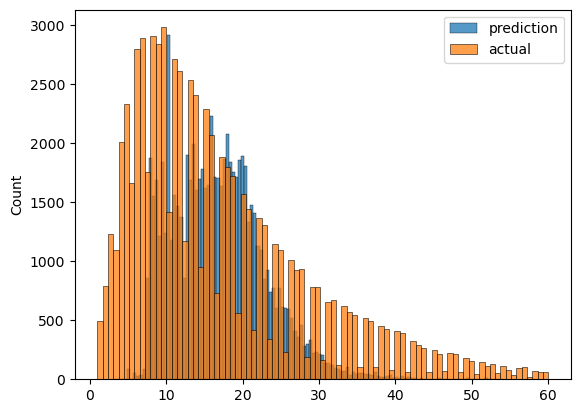

In [14]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [15]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [16]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [17]:
len(df_train), len(df_val)

(73908, 61921)

In [18]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [19]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206462274

In [22]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [45]:
with mlflow.start_run():
    mlflow.set_tag("developer", "Dinesh")
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickel")
#     mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [28]:
import xgboost as xgb


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [29]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [39]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, "validation")],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    return {'rmse': rmse, 'status': STATUS_OK}
        


In [41]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[11:42:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:10.87516                                                                                                                      
[1]	validation-rmse:7.80985                                                                                                                       
[2]	validation-rmse:7.02128                                                                                                                       
[3]	validation-rmse:6.79708                                                                                                                       
[4]	validation-rmse:6.72751                                                                                                                       
[5]	validation-rmse:6.69997                       

[54]	validation-rmse:6.55399                                                                                                                      
[55]	validation-rmse:6.55281                                                                                                                      
[56]	validation-rmse:6.55031                                                                                                                      
[57]	validation-rmse:6.54915                                                                                                                      
[58]	validation-rmse:6.54861                                                                                                                      
[59]	validation-rmse:6.54713                                                                                                                      
[60]	validation-rmse:6.54603                                                                                          

job exception: 



  0%|                                                                                                      | 0/50 [00:05<?, ?trial/s, best loss=?]


InvalidLoss: 

In [42]:


params = {
    'learning_rate':0.6127926351839442,
    'max_depth': 7,
    'min_child_weight': 1.0692866548579312,
    'objective': 'reg:linear',
    'reg_alpha': 0.13823297640386678,
    'reg_lambda': 0.005984355718193455,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=5
)


2023/05/25 12:23:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '631e611da67f4a728d2653d31edb48ef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[12:23:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:10.87516
[1]	validation-rmse:7.80985
[2]	validation-rmse:7.02128
[3]	validation-rmse:6.79708
[4]	validation-rmse:6.72751
[5]	validation-rmse:6.69997
[6]	validation-rmse:6.67856
[7]	validation-rmse:6.67478
[8]	validation-rmse:6.66756
[9]	validation-rmse:6.66263
[10]	validation-rmse:6.65794
[11]	validation-rmse:6.65468
[12]	validation-rmse:6.65199
[13]	validation-rmse:6.64891
[14]	validation-rmse:6.64806
[15]	validation-rmse:6.64412
[16]	validation-rmse:6.64108
[17]	validation-rmse:6.63944
[18]	validation-rmse:6.63702
[19]	validation-rmse:6.63520
[20]	validation-rmse:6.63393
[21]	validation-rmse:6.62814
[22]	validation-rmse:6.62537
[23]	validation-rmse:6.62062
[24]	validation-rmse:6.61699
[25]	validation-rmse:6.61386
[26]	validation-rmse:6.60975
[27]	valida

2023/05/25 12:24:05 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/25 12:24:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [47]:
mlflow.xgboost.autolog(disable=True)

In [48]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    
    best_params = {
        'learning_rate':0.6127926351839442,
        'max_depth': 7,
        'min_child_weight': 1.0692866548579312,
        'objective': 'reg:linear',
        'reg_alpha': 0.13823297640386678,
        'reg_lambda': 0.005984355718193455,
        'seed': 42
    }
    
    mlflow.log_params(best_params)
    
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, "validation")],
        early_stopping_rounds=5
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact('models/preprocessor.b', artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

[13:05:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:10.87516
[1]	validation-rmse:7.80985
[2]	validation-rmse:7.02128
[3]	validation-rmse:6.79708
[4]	validation-rmse:6.72751
[5]	validation-rmse:6.69997
[6]	validation-rmse:6.67856
[7]	validation-rmse:6.67478
[8]	validation-rmse:6.66756
[9]	validation-rmse:6.66263
[10]	validation-rmse:6.65794
[11]	validation-rmse:6.65468
[12]	validation-rmse:6.65199
[13]	validation-rmse:6.64891
[14]	validation-rmse:6.64806
[15]	validation-rmse:6.64412
[16]	validation-rmse:6.64108
[17]	validation-rmse:6.63944
[18]	validation-rmse:6.63702
[19]	validation-rmse:6.63520
[20]	validation-rmse:6.63393
[21]	validation-rmse:6.62814
[22]	validation-rmse:6.62537
[23]	validation-rmse:6.62062
[24]	validation-rmse:6.61699
[25]	validation-rmse:6.61386
[26]	validation-rmse:6.60975
[27]	valida

In [49]:
logged_model = 'runs:/c00ca5ecfd664afab73d998779a6e9b1/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



2023/05/25 13:08:53 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[13:08:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: c00ca5ecfd664afab73d998779a6e9b1

In [53]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[13:16:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
xgboost_model

In [55]:
y_pred = xgboost_model.predict(valid)

In [56]:
y_pred[:10]

array([16.39159  ,  6.9966426, 15.4420395, 24.553602 ,  9.19681  ,
       17.379328 , 14.191267 ,  9.149889 ,  8.868816 , 18.87749  ],
      dtype=float32)